In [1]:
# matplotlib es una librería de Python especializada en la creación de gráficos en dos dimensiones.
import matplotlib.pyplot as plt
# NumPy es una librería de Python especializada en el cálculo numérico
# y el análisis de datos, especialmente para un gran volumen de datos.
import numpy as np

import os
import PIL
import tensorflow as tf
import glob

# Keras es un framework de alto nivel para el aprendizaje,
# escrito en Python y capaz de correr sobre el framework TensorFlow.
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Cargamos las imágenes sin los equipos de protección y con los equipos de protección
from google.colab import files
uploaded = files.upload()

Saving elementosProteccion.zip to elementosProteccion.zip


In [7]:
# Importamos las librerías para manejar los diferentes tipos de formatos
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['elementosProteccion.zip']), 'r')  
data.extractall()

In [19]:
# Definimos los directorios
import pathlib
data_dir = tf.keras.utils.get_file('/content/Correctas','/content/Correctas',)
data_dir = pathlib.Path(data_dir)
print(data_dir)

/content/Correctas


In [20]:
# Se crea la variable que contará la cantidad de los archivos
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

0


In [45]:
nousaproteccion = list(data_dir.glob('/*')) 
PIL.Image.open(str(nousaproteccion[0]))

NotImplementedError: ignored

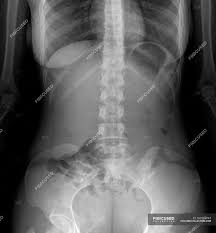

In [ ]:
sin_escoliosis = list(data_dir.glob('usaproteccion/*')) 
PIL.Image.open(str(sin_escoliosis[0]))

In [ ]:
batch_size = 32 # Muestras para el entrenamiento
img_height = 180 # Definimos la altura de las imágenes a 180
img_width = 180 # Definimos el ancho de las imágenes a 180

In [ ]:
# Procesamos las imágenes sin protección para el entrenamiento
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123, 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 93 files belonging to 2 classes.
Using 75 files for training.


In [ ]:
# Procesamos las imágenes sin protección para la validación
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 93 files belonging to 2 classes.
Using 18 files for validation.


In [ ]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
class_names =train_ds.class_names
print(class_names)

['columnaescoliotica', 'columnanormal']


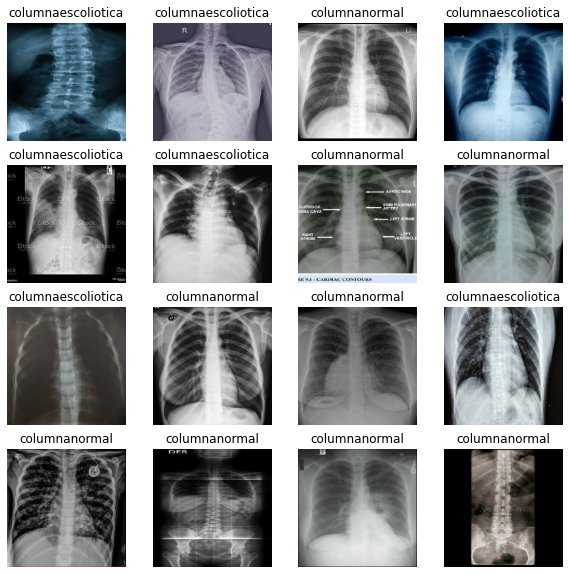

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Array de 32 imágenes
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
# Usamos Datasat_cache()
# Dataset_Prefetch superpone el procesamiento y la ejecución del modelo durante el entrenamiento
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
# Escalamos la información y se usa un rango de 0 a 255 para interpretar los valores RGB
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x,y: (normalization_layer(x),y))
image_batch, labels_batch= next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = 4
# Configuramos el modelo con 3 capas convolucionales en 2D con 16, 32, 64 nodos
# También definimos la densidad con 128 unidades
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'), 
  layers.Dense(num_classes)
])

In [ ]:
# El modelo se completa con el optimizador ADAM 
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),                                         
metrics=['accuracy'])

In [ ]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

In [ ]:
# Realizamos un Entrenamiento con 20 epocas
# Se debe tener en cuenta que para una muestra más pequeña, se necesita una mayor cantidad de epocas
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
3/3 [==============================] - 3s 1s/step - loss: 0.9994 - accuracy: 0.5200 - val_loss: 1.0231 - val_accuracy: 0.5556
Epoch 2/20
3/3 [==============================] - 2s 911ms/step - loss: 0.7998 - accuracy: 0.5333 - val_loss: 0.8084 - val_accuracy: 0.4444
Epoch 3/20
3/3 [==============================] - 2s 902ms/step - loss: 0.6895 - accuracy: 0.6000 - val_loss: 0.8449 - val_accuracy: 0.4444
Epoch 4/20
3/3 [==============================] - 2s 643ms/step - loss: 0.6349 - accuracy: 0.6267 - val_loss: 0.6550 - val_accuracy: 0.6111
Epoch 5/20
3/3 [==============================] - 2s 651ms/step - loss: 0.5071 - accuracy: 0.7067 - val_loss: 0.7185 - val_accuracy: 0.5000
Epoch 6/20
3/3 [==============================] - 2s 650ms/step - loss: 0.4168 - accuracy: 0.8267 - val_loss: 0.8053 - val_accuracy: 0.5000
Epoch 7/20
3/3 [==============================] - 2s 657ms/step - loss: 0.3746 - accuracy: 0.8400 - val_loss: 0.7105 - val_accuracy: 0.5556
Epoch 8/20
3/3 [=======

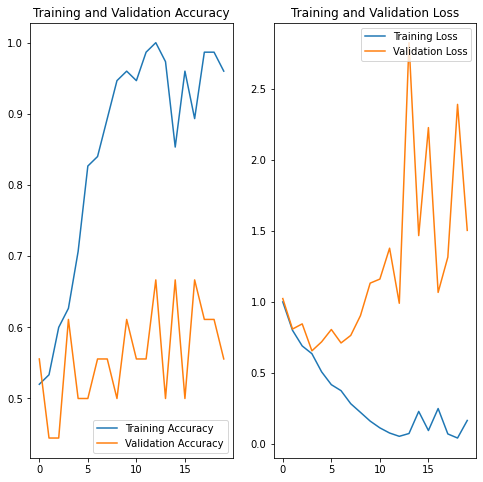

In [ ]:
# Asignamos de valores
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Definimos las epocas
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Ejecutamos el modelo
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

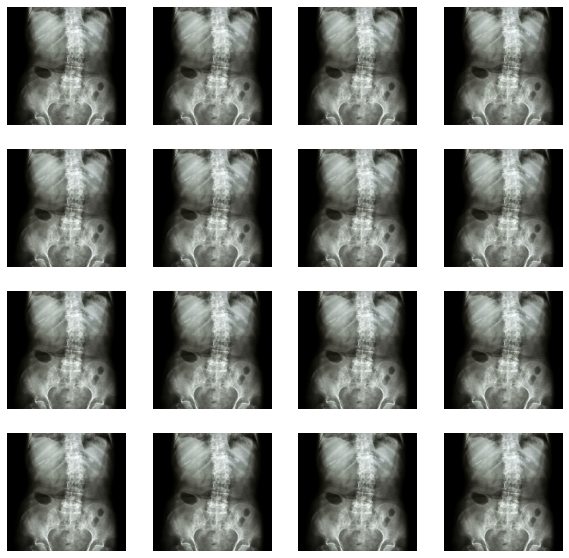

In [ ]:
# Agregamos los valores en la matriz de imagenes
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(16):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Pasamos el modelo secuencial donde se adicionan las capas convolucionales
# usando la funcion de activacion RELU
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(16, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
# Se compila modelo de optimizacion adam
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Minimizando la perdida del entrenamiento
keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=0, mode='min')

In [ ]:
# Se realiza un entrenamiento de 20 epocas
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
3/3 [==============================] - 6s 1s/step - loss: 1.3563 - accuracy: 0.2133 - val_loss: 1.0176 - val_accuracy: 0.5556
Epoch 2/20
3/3 [==============================] - 5s 1s/step - loss: 1.1186 - accuracy: 0.4000 - val_loss: 0.9126 - val_accuracy: 0.5556
Epoch 3/20
3/3 [==============================] - 5s 1s/step - loss: 1.0402 - accuracy: 0.4000 - val_loss: 0.8803 - val_accuracy: 0.5556
Epoch 4/20
3/3 [==============================] - 5s 1s/step - loss: 1.0195 - accuracy: 0.4000 - val_loss: 0.9005 - val_accuracy: 0.5556
Epoch 5/20
3/3 [==============================] - 5s 2s/step - loss: 1.0009 - accuracy: 0.4000 - val_loss: 0.8716 - val_accuracy: 0.5556
Epoch 6/20
3/3 [==============================] - 5s 1s/step - loss: 0.9934 - accuracy: 0.4000 - val_loss: 0.8663 - val_accuracy: 0.5556
Epoch 7/20
3/3 [==============================] - 5s 1s/step - loss: 0.9823 - accuracy: 0.4000 - val_loss: 0.8650 - val_accuracy: 0.5556
Epoch 8/20
3/3 [=========================

<function matplotlib.pyplot.plot>

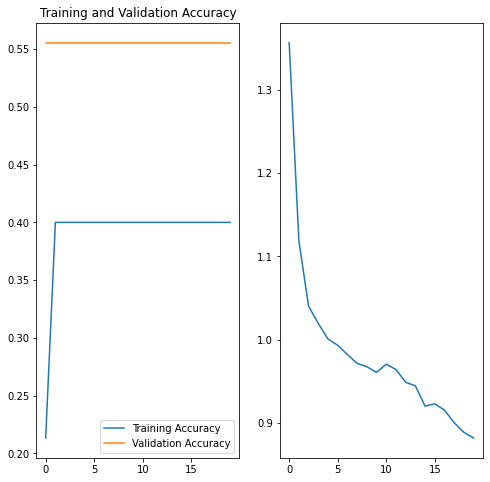

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot

Text(0.5, 1.0, 'Training and Validation Accuracy')

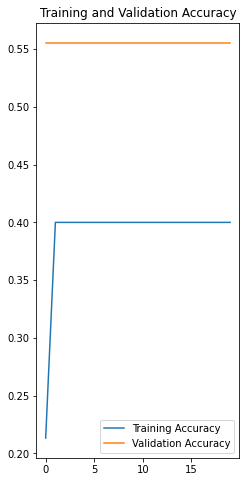

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

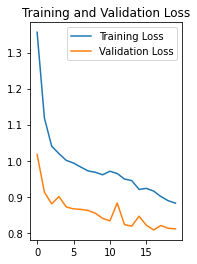

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving pruebas.zip to pruebas (1).zip


In [ ]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['pruebas.zip']), 'r')
data.extractall()

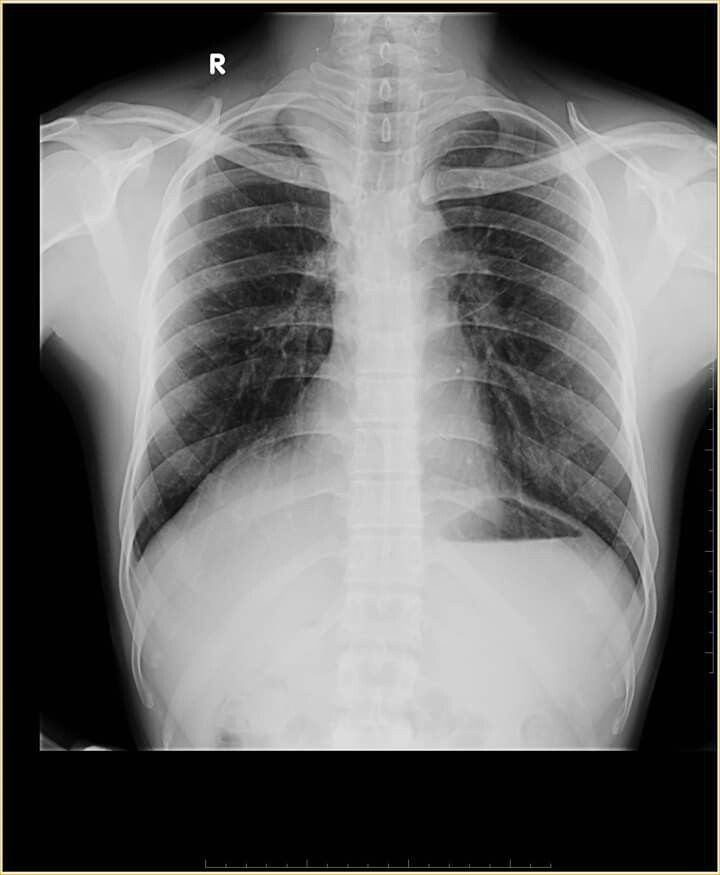

In [ ]:
from IPython.display import Image
Image(filename='/content/pruebas/ab31e3cd9de465d84131a9765d237e22.jpg')

In [ ]:
sitioDiag= {'nousaproteccion' : 'No usa el equipo de Protección' ,'usaproteccion' : 'Usa el equipo de Protección'}

In [ ]:
sunflower_url = "/content/pruebas/ab31e3cd9de465d84131a9765d237e22.jpg"
sunflower_path = tf.keras.utils.get_file('///content/pruebas/ab31e3cd9de465d84131a9765d237e22.jpg', '/content/pruebas/')

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("{} La probabilidad del acierto de que se presente la detección de la falta del equipo de Protección es: {:.2f}%".
      format(sitioDiag [class_names[np.argmax(score)]], 100 * np.max(score))
)


Columna no presenta desviaciones La probabilidad del acierto de que se presente escoleosis es: 84.98%
